# Overview

This experiment uses Convolutional Neural Network (CNN) and is implemented in Keras (based on Tensorflow) to predict movie genres based on the plot synopsis. It is trained on $42,000$ movies retrieved from IMDB and Wikipedia.

Some sample outputs:

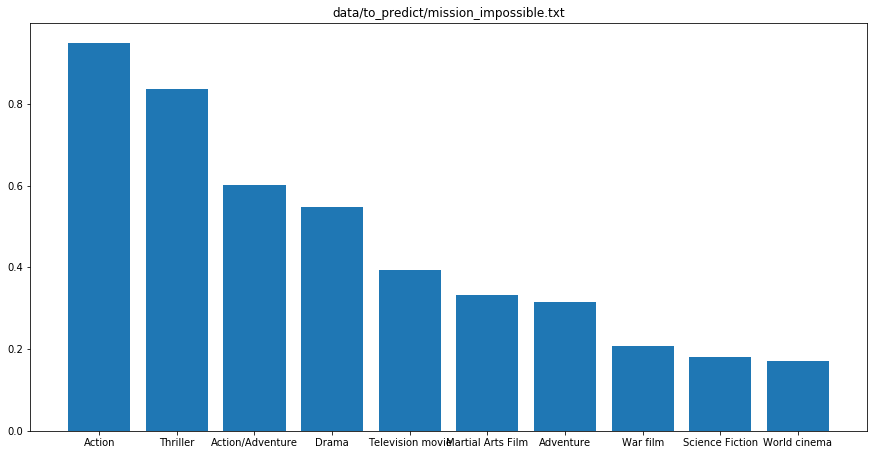

In [29]:
# Predict Mission Impossible: Action, Thriller, Adventure, Crime Fiction
predict_movie_genre(model_multi,'data/to_predict/mission_impossible.txt',genres_np,True,10)

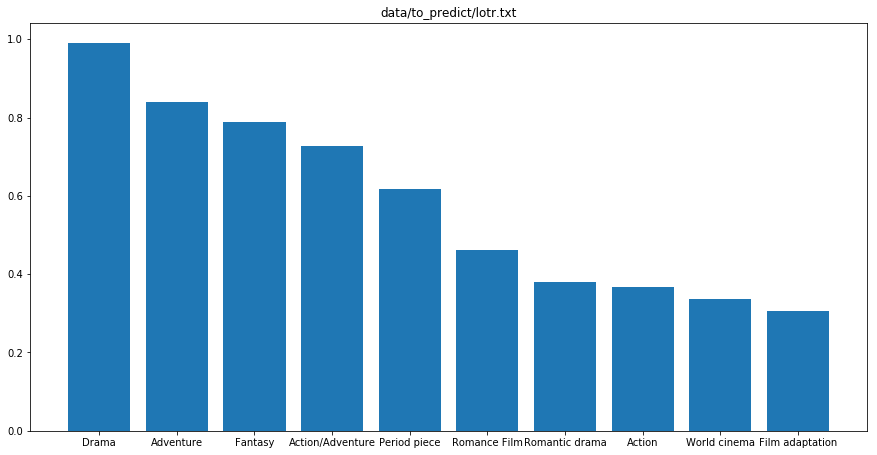

In [30]:
# Predict Lord of the Rings: Action, Adventure, Drama, Fantasy, etc.
predict_movie_genre(model_multi,'data/to_predict/lotr.txt',genres_np,True,10)

The data is downloaded from <http://www.cs.cmu.edu/~ark/personas/data/MovieSummaries.tar.gz>

It is also possible to develop a scrapper to scrap the details from IMDB.

# 1. Load data

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 7.5)

synopsis=pd.read_csv('data/plot_summaries.txt',header=None,delimiter='\t')

In [43]:
synopsis.columns=['id','text']
synopsis.head()

,id,text
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


In [3]:
movies_meta=pd.read_csv('data/movie.metadata.tsv',header=None,delimiter='\t')
movies_meta.head()

,0,1,2,3,4,5,6,7,8
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp..."
2,28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D..."
3,9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic..."
4,261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}"


In [4]:
movies_genre=movies_meta[[0,8]]
movies_genre.columns=['id','genres']
movies_genre['genres']=movies_genre['genres'].apply(eval).apply(lambda x: list(x.values()))

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [5]:
movies_genre.iloc[0]

id                                                   975900
genres    [Thriller, Science Fiction, Horror, Adventure,...
Name: 0, dtype: object

Join these 2 tables to get id-synopsis-genre

In [6]:
data=synopsis.set_index('id').join(movies_genre.set_index('id'))

In [7]:
data=data.dropna()
#data.to_csv('id-syn-genres.csv')

In [8]:
data.head()

,text,genres
id,,
23890098,"Shlykov, a hard-working taxi driver and Lyosha...","[Drama, World cinema]"
31186339,The nation of Panem consists of a wealthy Capi...,"[Action/Adventure, Science Fiction, Action, Dr..."
20663735,Poovalli Induchoodan is sentenced for six yea...,"[Musical, Action, Drama, Bollywood]"
2231378,"The Lemon Drop Kid , a New York City swindler,...","[Screwball comedy, Comedy]"
595909,Seventh-day Adventist Church pastor Michael Ch...,"[Crime Fiction, Drama, Docudrama, World cinema..."


Preprocess data for text processing using Keras

Apply One hot encoder on the labels first

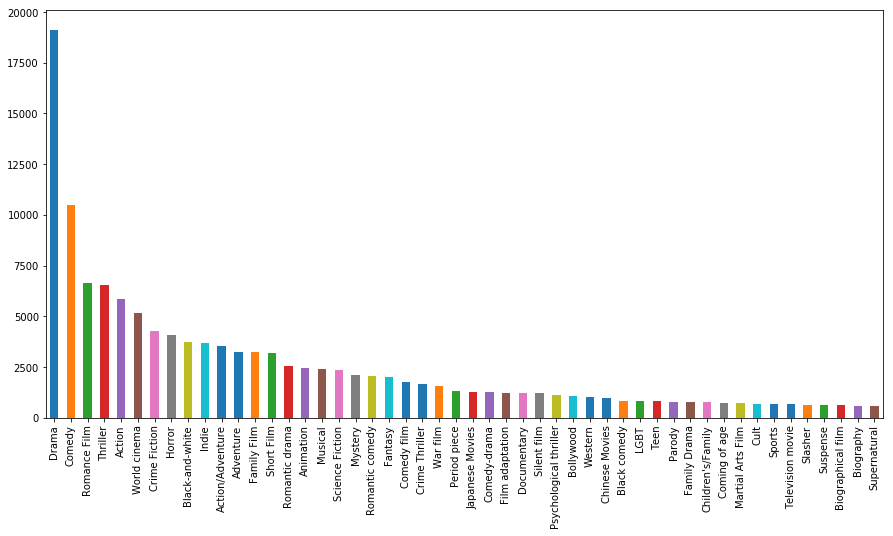

In [13]:
total_genres=[]

#flatten all genres
for movie in data['genres'].values:
    total_genres.extend(movie)

#There are many genres (363), to simplify the first run, let's shortlist only the top common genres
all_genres=pd.Series(total_genres)
genre_counts=all_genres.value_counts()
genre_counts[:50].plot(kind='bar')

#Only take 50 top common genres
all_genres=genre_counts.nlargest(50).index.tolist()

In [14]:
#one hot encoder or get_dummies don't really work
#there are multiple labels in non consistent order. Manually categorize the genre
labels=(np.in1d(all_genres,data['genres'].values[0]))

for i in range(1,data['genres'].shape[0]):
    labels=np.vstack((labels,np.in1d(all_genres,data['genres'].values[i])))

labels=labels.astype(int)
labels.shape

(42204, 50)

# 2. Preprocess the texts

In [15]:
import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(data['text'].values,labels)

vocab_size=10000
tokenizer=Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(data['text'].values)

X_train_tokenized=tokenizer.texts_to_matrix(X_train,mode='tfidf')
X_test_tokenized=tokenizer.texts_to_matrix(X_test,mode='tfidf')

Using TensorFlow backend.


# 3. Build the first model

In [14]:
model=Sequential()
#depth of 1
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))

#drop some units for regularization here
model.add(Dropout(0.25))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# 363 genres in total - too many think of reducing 
model.add(Dense(len(all_genres)))

#fully connected layer
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

out=model.fit(X_train_tokenized,y_train,epochs=5,verbose=1)

Epoch 1/5
31653/31653 [==============================] - 45s 1ms/step - loss: 8.9854 - acc: 0.4238
Epoch 2/5
31653/31653 [==============================] - 43s 1ms/step - loss: 7.4982 - acc: 0.4443
Epoch 3/5
31653/31653 [==============================] - 43s 1ms/step - loss: 6.7681 - acc: 0.4473
Epoch 4/5
31653/31653 [==============================] - 43s 1ms/step - loss: 6.3754 - acc: 0.4568
Epoch 5/5
31653/31653 [==============================] - 43s 1ms/step - loss: 6.1233 - acc: 0.4635


In [41]:
#Save the model first before proceeding
import pickle
model.save('movie_genre_5_epochs')
fp=open('tokenizer.pickle','wb')
pickle.dump(tokenizer,fp)

The accuracy converges after 3th epoch and it looks like it doesn't increase much afterwards. The accuracy is not so good. 

## Potential problems to solve:
1. Too many classes in the labels?
2. The tuning of parameters?
3. Haven't dealt with unbalanced numbers of labels (much more actions movies than Screwball Comedy)
4. The labels are exclusive (total sum to 1). It is probably necessary to tune the model to do multi-label classification (a movie can belong to multiple genres)

Let's see how it predicts first, and confirm the $4^{th}$ point (synopsis taken from IMDB)

## Predict a few movies

(array(['Thriller', 'Action', 'Action/Adventure', 'Adventure', 'Drama',
        'Martial Arts Film', 'War film', 'Crime Fiction',
        'Science Fiction', 'Film adaptation'], dtype='<U22'),
 array([0.338108  , 0.2607331 , 0.11694376, 0.10165188, 0.08087367,
        0.02253665, 0.02189998, 0.01494369, 0.00963372, 0.00746756],
       dtype=float32))

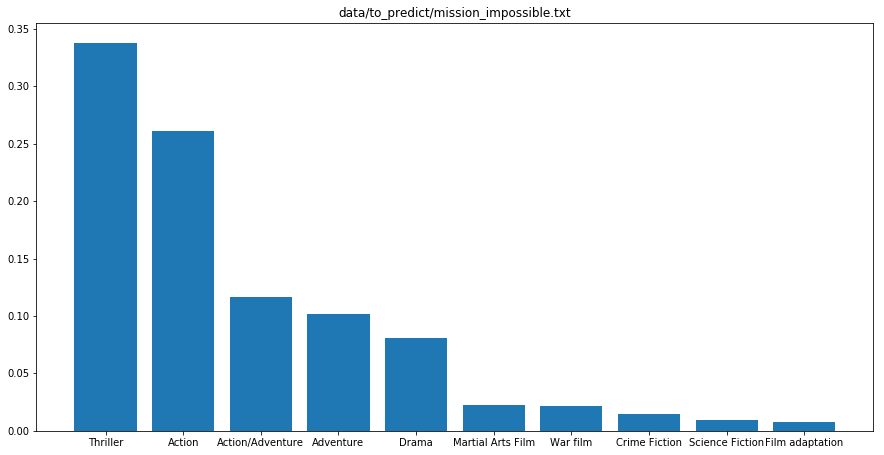

In [17]:
def predict_movie_genre(model,syn,genres_np,to_plot=False,top_scores=3):
    """Given a plot synopsis, predict the genre"""
    syn_data=open(syn).read()
    syn_tokenized=tokenizer.texts_to_matrix(np.array([syn_data]),mode='tfidf')
    syn_predicted=model.predict(syn_tokenized)
    
    #See the top predicted classification
    #get the top genres, in descending order of probs
    #Last `top_scores` is still ascending, hence reverse it.
    genres_txt=genres_np[np.ravel(syn_predicted).argsort()[-top_scores:][::-1]]
    probs=np.sort(np.ravel(syn_predicted))[::-1][:top_scores]
    if to_plot:
        plt.bar(np.arange(0,top_scores),probs,tick_label=genres_txt)
        plt.title(syn)
        
    return genres_txt, probs

genres_np=np.array(all_genres)
predict_movie_genre(model,'data/to_predict/mission_impossible.txt',genres_np,True,10)

(array(['Drama', 'Action', 'Adventure', 'Action/Adventure', 'Romance Film',
        'Period piece', 'Thriller', 'Film adaptation', 'World cinema',
        'Science Fiction'], dtype='<U22'),
 array([0.22355066, 0.1430243 , 0.12226483, 0.0758467 , 0.06458318,
        0.06225162, 0.04849501, 0.04665682, 0.02991931, 0.02364179],
       dtype=float32))

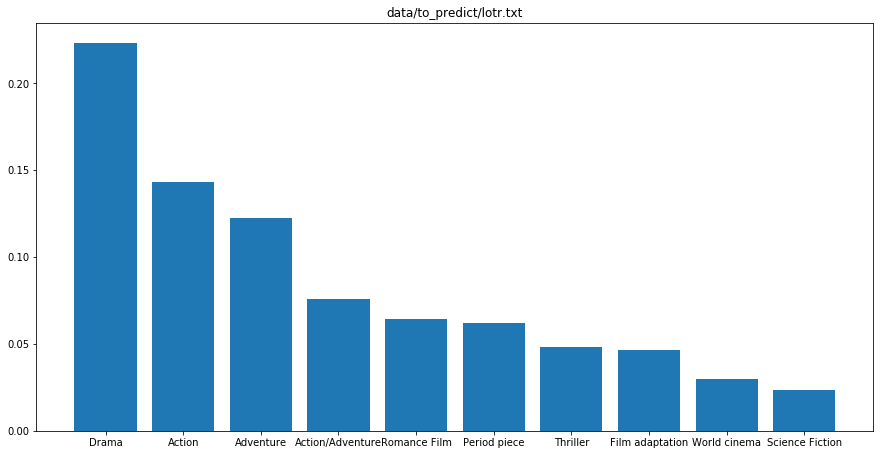

In [18]:
#Lord of the rings
predict_movie_genre(model,'data/to_predict/lotr.txt',genres_np,True,10)

# 4. Multi-label classification model
The above confirms that the genres are exclusive (and fighting for the 1 probability). All predicted probabilities of a movie sum to 1. The model needs to be adjusted to do multi-label classification.

In [19]:
model_multi=Sequential()
#depth of 1
model_multi.add(Dense(512, input_shape=(vocab_size,)))
model_multi.add(Activation('relu'))

#drop some nodes for regularization here
model_multi.add(Dropout(0.25))

model_multi.add(Dense(512))
model_multi.add(Activation('relu'))
model_multi.add(Dropout(0.25))

# 50 genres in total
model_multi.add(Dense(len(all_genres)))

#use sigmoid at the last layer activation, and binary_crossentropy
#for multi label classification
#https://towardsdatascience.com/multi-label-classification-and-class-activation-map-on-fashion-mnist-1454f09f5925
model_multi.add(Activation('sigmoid'))
model_multi.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

#introduce validation split to avoid overfitting
out=model_multi.fit(X_train_tokenized,y_train,epochs=5,verbose=1,validation_split=0.25)
model_multi.save('model_multi_movie_genre_5_epochs')

Train on 23739 samples, validate on 7914 samples
Epoch 1/5
23739/23739 [==============================] - 36s 2ms/step - loss: 0.1720 - acc: 0.9440 - val_loss: 0.1451 - val_acc: 0.9498
Epoch 2/5
23739/23739 [==============================] - 35s 1ms/step - loss: 0.1135 - acc: 0.9579 - val_loss: 0.1497 - val_acc: 0.9477
Epoch 3/5
23739/23739 [==============================] - 35s 1ms/step - loss: 0.0802 - acc: 0.9697 - val_loss: 0.1640 - val_acc: 0.9431
Epoch 4/5
23739/23739 [==============================] - 35s 1ms/step - loss: 0.0628 - acc: 0.9768 - val_loss: 0.1770 - val_acc: 0.9431
Epoch 5/5
23739/23739 [==============================] - 35s 1ms/step - loss: 0.0529 - acc: 0.9807 - val_loss: 0.1878 - val_acc: 0.9432


The accuracy looks better now. Let's test with a few examples for multi-label classification, before verify with the test set, and look more into 

(array(['Action', 'Thriller', 'Action/Adventure', 'Drama',
        'Television movie', 'Martial Arts Film', 'Adventure', 'War film',
        'Science Fiction', 'World cinema'], dtype='<U22'),
 array([0.9500469 , 0.8374492 , 0.60239506, 0.5471541 , 0.39380592,
        0.33235618, 0.31497368, 0.20679784, 0.18017067, 0.17082176],
       dtype=float32))

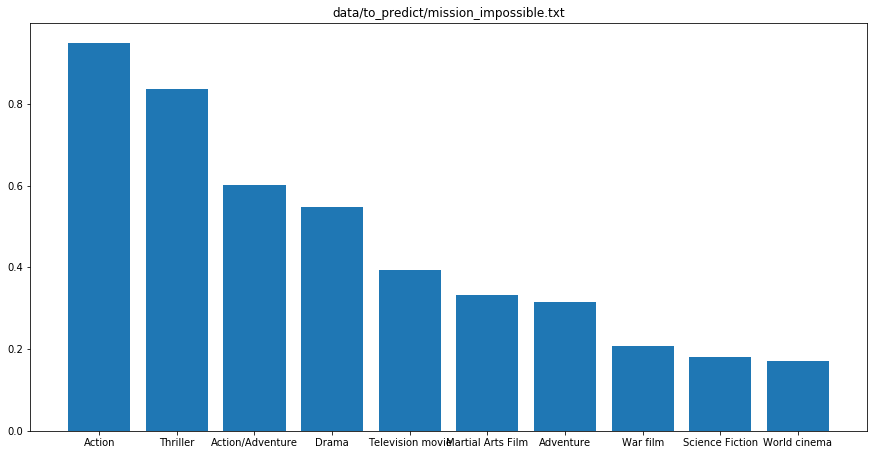

In [20]:
predict_movie_genre(model_multi,'data/to_predict/mission_impossible.txt',genres_np,True,10)

(array(['Drama', 'Adventure', 'Fantasy', 'Action/Adventure',
        'Period piece', 'Romance Film', 'Romantic drama', 'Action',
        'World cinema', 'Film adaptation'], dtype='<U22'),
 array([0.9915274 , 0.8386744 , 0.7875657 , 0.7260934 , 0.6173456 ,
        0.46168262, 0.3787121 , 0.36742234, 0.3356341 , 0.3049874 ],
       dtype=float32))

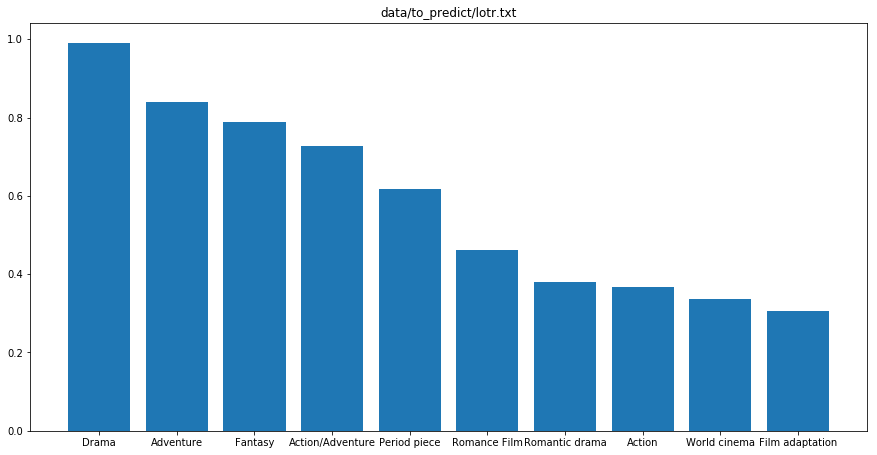

In [21]:
predict_movie_genre(model_multi,'data/to_predict/lotr.txt',genres_np,True,10)

(array(['Fantasy', 'Animation', 'Family Film', 'Coming of age',
        "Children's/Family", 'Drama', 'Japanese Movies', 'Adventure',
        'Teen', 'Romance Film'], dtype='<U22'),
 array([0.9384023 , 0.878138  , 0.8511521 , 0.7166215 , 0.6991525 ,
        0.5567561 , 0.50401556, 0.47395167, 0.09134953, 0.06717162],
       dtype=float32))

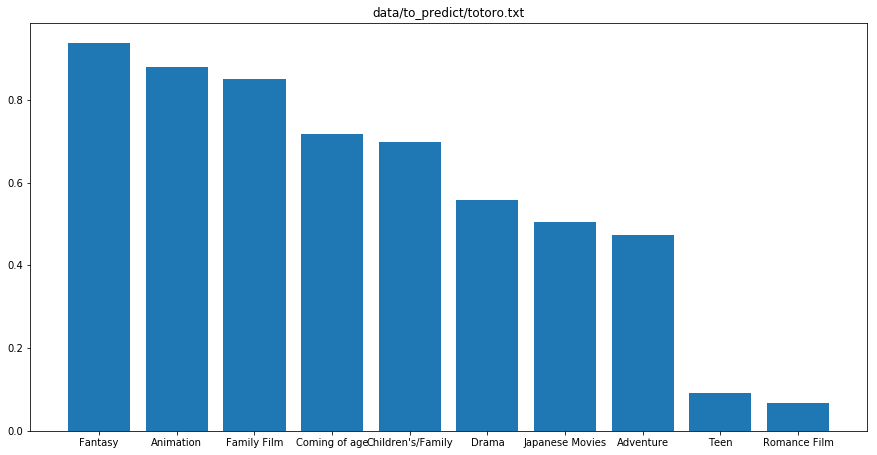

In [22]:
predict_movie_genre(model_multi,'data/to_predict/totoro.txt',genres_np,True,10)

The classification for 3 movies above look acceptable.

## Verify with Test set

In [23]:
model_multi.evaluate(X_test_tokenized,y_test)

10551/10551 [==============================] - 2s 204us/step


[0.18834575361752892, 0.9427978492677974]

Compared with the training accuracy this accuracy (0.9427) indicates the model is not overfitted.

Accuracy might not be the best metrics in this case for 2 reasons:
1. The problem of imbalanced class (as below).
1. Accuracy is designed for binary classification. This is a problem of multi-label classification.

**Ranking Loss** is a more appropriate metric.

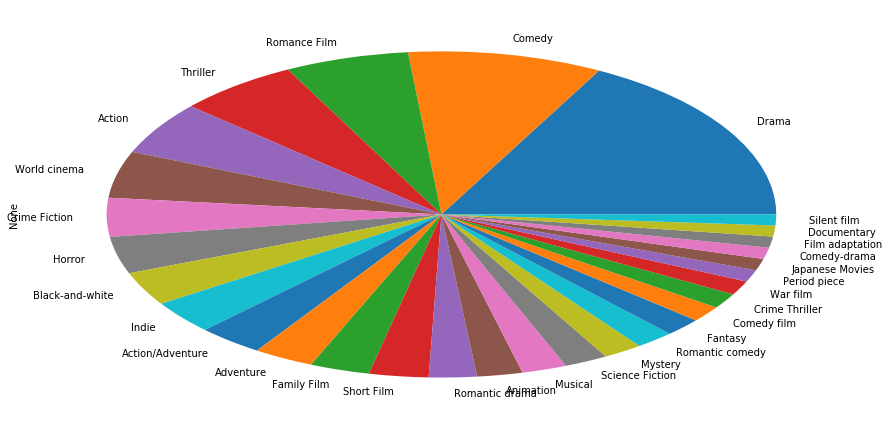

In [24]:
genre_counts[:30].plot(kind='pie')

In [26]:
# http://scikit-learn.org/stable/modules/model_evaluation.html#multilabel-ranking-metrics
# http://scikit-learn.org/stable/modules/model_evaluation.html#ranking-loss
from sklearn.metrics import label_ranking_loss
y_pred=model_multi.predict(X_test_tokenized)

label_ranking_loss(y_test,y_pred)

0.09999542560280986

The ranking loss is near 0.099 (with 0.0 being the best achievable score). This indicates the performance is good.

# 5. Further improve the model using word embedding

Let's use Word Embedding to improve the performance of the model

In [ ]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.layers import Flatten

#keep crashing the kernel, try with a smaller vocab size
vocab_size=2000
tokenizer_s=Tokenizer(num_words=vocab_size)
tokenizer_s.fit_on_texts(data['text'].values)

X1_train_tokenized=tokenizer_s.texts_to_matrix(X_train,mode='tfidf')
X1_test_tokenized=tokenizer_s.texts_to_matrix(X_test,mode='tfidf')

In [37]:
model_word_embedding=Sequential()

#add embedding as the first layer
model_word_embedding.add(Embedding(vocab_size,50,input_shape=(vocab_size,)))
model_word_embedding.add(Flatten())

model_word_embedding.add(Dense(512))
model_word_embedding.add(Activation('relu'))

#drop some nodes for regularization here
model_word_embedding.add(Dropout(0.25))

model_word_embedding.add(Dense(512))
model_word_embedding.add(Activation('relu'))
model_word_embedding.add(Dropout(0.25))
model_word_embedding.add(Dense(len(all_genres)))

#sigmoid and binary_crossentropy for multi label classification
model_word_embedding.add(Activation('sigmoid'))
model_word_embedding.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

out=model_word_embedding.fit(X1_train_tokenized,y_train,epochs=2,verbose=1,validation_split=0.25)
model_word_embedding.save('model_embedding_movie_genre_5_epochs')

Train on 23739 samples, validate on 7914 samples
Epoch 1/2
23739/23739 [==============================] - 304s 13ms/step - loss: 0.1814 - acc: 0.9415 - val_loss: 0.1505 - val_acc: 0.9474
Epoch 2/2
23739/23739 [==============================] - 302s 13ms/step - loss: 0.1453 - acc: 0.9486 - val_loss: 0.1503 - val_acc: 0.9479


In [40]:
model_word_embedding.evaluate(X1_test_tokenized,y_test)

10551/10551 [==============================] - 15s 1ms/step


[0.1502491502389107, 0.9482494695086511]

Using a smaller vocab size, this approach still achieves slightly higher performance than the previous approach.

The next steps:
1. Figure out exactly why it crashes (with larger vocab sizes and higher dim)
1. Settings of hyper parameters and the design of the network